# Imports

In [1]:
import json
import logging
import os
from datetime import timedelta

import pandas as pd
import requests

import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.hpandas as hpandas
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.ccxt.data.extract.exchange_class as imvcdeexcl

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-b1200c2b-21f2-4771-826f-a2f5c748b4ad.json'


## CCXT Historical Client

In [3]:
# Specify params.
universe_version = "v3"
resample_1min = True
root_dir = os.path.join("s3://cryptokaizen-data", "historical")
partition_mode = "by_year_month"
data_snapshot = "latest"
aws_profile = "ck"

# Initiate the client.
historical_client = icdcl.CcxtHistoricalPqByTileClient(
    universe_version,
    resample_1min,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



## Crypto-chassis Historical

In [4]:
def load_crypto_chassis_ohlcv(exhange_id, currency_pair):
    r = requests.get(
        f"https://api.cryptochassis.com/v1/ohlc/{exhange_id}/{currency_pair}?startTime=0"
    )
    df = pd.read_csv(r.json()["historical"]["urls"][0]["url"], compression="gzip")
    df["time_seconds"] = df["time_seconds"].apply(
        lambda x: hdateti.convert_unix_epoch_to_timestamp(x, unit="s")
    )
    df = df.set_index("time_seconds")
    return df

# `Kucoin` case

## Example that the data is available in other sources

### `full_symbol` = kucoin::ADA_USDT

#### Load the data

In [4]:
# Load historical data from CCXT.
full_symbols = ["kucoin::ADA_USDT"]
start_date = None
end_date = None
ada_kucoin_ccxt = historical_client.read_data(
    full_symbols, start_date, end_date, columns=None
)
# Load historical data from crypto-chassis.
ada_kucoin_ch = load_crypto_chassis_ohlcv("kucoin", "ada-usdt")

#### Take a specific period of time - [2022-02-09 00:00, 2022-02-09 13:33]

In [6]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2022-02-09 00:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2022-02-09 13:33:00+00:00")
]
chassis_ada = ada_kucoin_ch.loc[
    (ada_kucoin_ch.index > "2022-02-09 00:00:00+00:00")
    & (ada_kucoin_ch.index < "2022-02-09 13:33:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(chassis_ada)}"
)

Both datasets have the same length: True


#### Data snapshot

In [7]:
print("Period of NaNs in CCXT:")
display(ccxt_ada_nans)
print("Complete data in chassis:")
display(chassis_ada)

Period of NaNs in CCXT:


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-02-09 00:01:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 00:02:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 00:03:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 00:04:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 00:05:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-02-09 13:28:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 13:29:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 13:30:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN


Complete data in chassis:


,open,high,low,close,volume,vwap,number_of_trades,twap
time_seconds,,,,,,,,
2022-02-09 00:01:00+00:00,1.177307,1.178705,1.175063,1.175063,12003.969501,1.177681,45,1.177442
2022-02-09 00:02:00+00:00,1.175181,1.175520,1.173825,1.175520,16526.710800,1.174580,55,1.174329
2022-02-09 00:03:00+00:00,1.174718,1.177135,1.174703,1.177135,4007.403653,1.175370,22,1.175291
2022-02-09 00:04:00+00:00,1.177380,1.177483,1.175778,1.176398,4263.086400,1.176756,21,1.176613
2022-02-09 00:05:00+00:00,1.176735,1.177533,1.175585,1.177533,838.080800,1.176068,15,1.176564
...,...,...,...,...,...,...,...,...
2022-02-09 13:28:00+00:00,1.207000,1.207000,1.206050,1.206050,1123.966604,1.206816,14,1.206619
2022-02-09 13:29:00+00:00,1.206414,1.207197,1.206224,1.206224,8912.159703,1.206663,30,1.206653
2022-02-09 13:30:00+00:00,1.206035,1.207835,1.205837,1.206707,14121.676417,1.206440,52,1.206477


In [8]:
print(
    f"Percentage of NaNs in CCXT data for the period: {len(ccxt_ada_nans[ccxt_ada_nans.open.isna()])*100/len(ccxt_ada_nans)}"
)
print(
    f"Percentage of NaNs in crypto-chassis data for the period: {len(chassis_ada[chassis_ada.open.isna()])*100/len(chassis_ada)}"
)

Percentage of NaNs in CCXT data for the period: 100.0
Percentage of NaNs in crypto-chassis data for the period: 0.0


### `full_symbol` = kucoin::BTC_USDT

This full symbol has the highest coverage according to https://github.com/cryptokaizen/cmamp/issues/1750#issuecomment-1106866542

#### Load the data

In [9]:
# Load historical data from CCXT.
full_symbols = ["kucoin::BTC_USDT"]
start_date = None
end_date = None
btc_kucoin_ccxt = historical_client.read_data(full_symbols, start_date, end_date)
# Load historical data from crypto-chassis.
btc_kucoin_ch = load_crypto_chassis_ohlcv("kucoin", "btc-usdt")

#### Take a specific period of time - a year 2021

In [10]:
ccxt_btc = btc_kucoin_ccxt.loc[
    (btc_kucoin_ccxt.index > "2021-08-07")
    & (btc_kucoin_ccxt.index < "2021-12-31")
]
chassis_btc = btc_kucoin_ch.loc[
    (btc_kucoin_ch.index > "2021-08-07") & (btc_kucoin_ch.index < "2021-12-31")
]

In [11]:
# From crypto-chassis docs:
# If there is a gap in "time_seconds", it means that
# the market depth snapshot at that moment is the same as the previous moment.
# It means that NaNs there are 'gaps' between timestamps.
chassis_btc["timestamp_diff"] = chassis_btc.index.to_series().diff()
# Exclude 1min gaps (means no NaNs) and calculate the num of mins in gaps (equals to num of NaNs).
chassis_btc[chassis_btc["timestamp_diff"] != "0 days 00:01:00"]
# Calculate the total rows with NaNs.
num_of_nans_chassis = chassis_btc["timestamp_diff"].sum() / timedelta(minutes=1)

/tmp/ipykernel_795/3470892466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chassis_btc["timestamp_diff"] = chassis_btc.index.to_series().diff()


In [12]:
print(
    f"NaNs percentage in CCXT for `kucoin::BTC_USDT` for 2021: {100*len(ccxt_btc[ccxt_btc.open.isna()])/len(ccxt_btc)}"
)
print(
    f"NaNs percentage in crypto-chassis for `kucoin::BTC_USDT` for 2021: {100*num_of_nans_chassis/(len(chassis_btc)+num_of_nans_chassis)}"
)

NaNs percentage in CCXT for `kucoin::BTC_USDT` for 2021: 71.24938760172947
NaNs percentage in crypto-chassis for `kucoin::BTC_USDT` for 2021: 50.43759056493326


#### Take a specific period of time - [2022-01-15 12:00, 2022-01-15 21:00]

In [13]:
ccxt_btc2022 = btc_kucoin_ccxt.loc[
    (btc_kucoin_ccxt.index > "2022-01-15 12:00:00")
    & (btc_kucoin_ccxt.index < "2022-01-15 21:00:00")
]
chassis_btc2022 = btc_kucoin_ch.loc[
    (btc_kucoin_ch.index > "2022-01-15 12:00:00")
    & (btc_kucoin_ch.index < "2022-01-15 21:00:00")
]
print(
    f"Both datasets have the same length: {len(ccxt_btc2022)==len(chassis_btc2022)}"
)

Both datasets have the same length: True


In [14]:
print("Period of NaNs in CCXT:")
display(ccxt_btc2022)
print("Complete data in chassis:")
display(chassis_btc2022)

Period of NaNs in CCXT:


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-01-15 12:01:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 12:02:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 12:03:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 12:04:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 12:05:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-01-15 20:55:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 20:56:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN
2022-01-15 20:57:00+00:00,kucoin::BTC_USDT,NaN,NaN,NaN,NaN,NaN


Complete data in chassis:


,open,high,low,close,volume,vwap,number_of_trades,twap
time_seconds,,,,,,,,
2022-01-15 12:01:00+00:00,43034.6,43051.1,43024.0,43024.0,2.398839,43039.149,148,43036.571
2022-01-15 12:02:00+00:00,43024.0,43036.4,43024.0,43024.1,1.806001,43026.580,139,43027.819
2022-01-15 12:03:00+00:00,43024.1,43024.1,42993.2,43001.3,1.868689,43006.890,118,43006.532
2022-01-15 12:04:00+00:00,43001.2,43001.2,42975.4,42975.4,2.727630,42985.147,198,42984.717
2022-01-15 12:05:00+00:00,42975.4,42993.3,42975.4,42978.5,4.419319,42984.413,273,42983.146
...,...,...,...,...,...,...,...,...
2022-01-15 20:55:00+00:00,43548.6,43554.9,43534.3,43534.3,2.742735,43548.523,290,43547.258
2022-01-15 20:56:00+00:00,43534.3,43556.8,43534.3,43548.6,1.459718,43536.923,230,43538.521
2022-01-15 20:57:00+00:00,43548.6,43548.7,43534.7,43544.9,1.172161,43539.147,209,43542.826


### Summary

From what we can see in comparison with other data vendors, __the problem of data coverage has little to do with the initial data provider__ (i.e., `kucoin`), since the NaN data in `CCXT` is available in other providers (`crypto-chassis`)

## Look at S3

In [15]:
# Take the previously spotted NaN sequence.
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2022-02-01 00:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2022-02-09 13:33:00+00:00")
]
ccxt_ada_nans

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-02-01 00:01:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-01 00:02:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-01 00:03:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-01 00:04:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-01 00:05:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-02-09 13:28:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 13:29:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2022-02-09 13:30:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN


In [16]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans[ccxt_ada_nans.open.isna()])/len(ccxt_ada_nans)}"
)

Percentage of NaN data: 100.0


S3 has the only file in the February for `kucoin::ADA_USDT`:

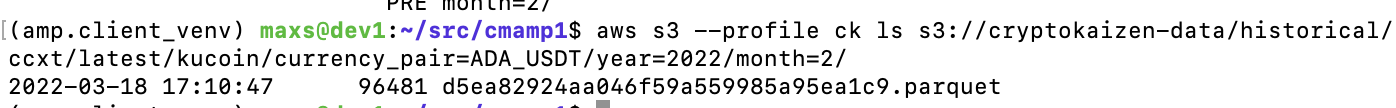

In [17]:
file_path = "s3://cryptokaizen-data/historical/ccxt/latest/kucoin/currency_pair=ADA_USDT/year=2022/month=2/d5ea82924aa046f59a559985a95ea1c9.parquet"
pq_ada = pd.read_parquet(file_path)
pq_ada

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2022-02-09 13:33:00+00:00,1644413580000,1.206142,1.206230,1.203018,1.203043,21254.676948
2022-02-09 13:34:00+00:00,1644413640000,1.203020,1.203590,1.202348,1.203590,23692.631791
2022-02-09 13:35:00+00:00,1644413700000,1.203532,1.204398,1.202777,1.202948,5288.444181
2022-02-09 13:36:00+00:00,1644413760000,1.203015,1.204108,1.202500,1.203753,15160.293667
2022-02-09 13:37:00+00:00,1644413820000,1.203613,1.203613,1.203212,1.203419,1320.846264
...,...,...,...,...,...,...
2022-02-10 14:28:00+00:00,1644503280000,1.161748,1.161748,1.159554,1.159554,19672.186803
2022-02-10 14:29:00+00:00,1644503340000,1.159554,1.161165,1.159554,1.160566,17144.714198
2022-02-10 14:30:00+00:00,1644503400000,1.160875,1.165150,1.160432,1.165150,35833.080863


One can notice that the data for February starts exactly from the point where NaN sequence is ending.

### Summary

The raw data doesn't have include the data for NaN sequences in client which means that with great probability, __the client doesn't distorts the raw data and it comes initially with these NaN sequences__.

# Load CCXT data using requests from CCXT

## Function

In [3]:
def timestamp_to_datetime(timestamps):
    times = []
    for time in timestamps:
        times.append(hdateti.convert_unix_epoch_to_timestamp(time))
    return times

## Load data

## Extractor

In [14]:
ccxt_kucoin_ada_exchange = imvcdeexcl.CcxtExchange("kucoin")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data("ADA/USDT")

In [17]:
# Nina: data is hard to load for the whole month using CcxtExchange. Duration of downloading more than 5 hours.
currency_pair = "ADA/USDT"
start_timestamp = pd.Timestamp("2019-08-30")
end_timestamp = pd.Timestamp("2019-08-31")
sleep_time_in_secs = 20
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.24s/it]


In [5]:
df = ccxt_kucoin_ada_data.copy()

In [8]:
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

,timestamp,open,high,low,close,volume,end_download_timestamp
2019-08-30 00:00:00+00:00,1567123200000,0.044399,0.044399,0.044399,0.044399,0.0,2022-05-03 15:11:52.822615+00:00
2019-08-30 00:01:00+00:00,1567123260000,0.044399,0.044399,0.044399,0.044399,0.0,2022-05-03 15:11:52.822615+00:00
2019-08-30 00:02:00+00:00,1567123320000,0.044399,0.044399,0.044399,0.044399,0.0,2022-05-03 15:11:52.822615+00:00
2019-08-30 00:03:00+00:00,1567123380000,0.044399,0.044399,0.044399,0.044399,0.0,2022-05-03 15:11:52.822615+00:00
2019-08-30 00:04:00+00:00,1567123440000,0.044399,0.044399,0.044399,0.044399,0.0,2022-05-03 15:11:52.822615+00:00
...,...,...,...,...,...,...,...
2019-08-31 00:55:00+00:00,1567212900000,0.044296,0.044296,0.044296,0.044296,0.0,2022-05-03 15:12:33.373629+00:00
2019-08-31 00:56:00+00:00,1567212960000,0.044296,0.044296,0.044296,0.044296,0.0,2022-05-03 15:12:33.373629+00:00
2019-08-31 00:57:00+00:00,1567213020000,0.044296,0.044296,0.044296,0.044296,0.0,2022-05-03 15:12:33.373629+00:00
2019-08-31 00:58:00+00:00,1567213080000,0.044296,0.044296,0.044296,0.044296,0.0,2022-05-03 15:12:33.373629+00:00


In [31]:
df.loc[df["volume"].isna()]

,timestamp,open,high,low,close,volume,end_download_timestamp


In [33]:
# 2020
start_timestamp = pd.Timestamp("2020-01-30")
end_timestamp = pd.Timestamp("2020-01-31")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.28s/it]


In [34]:
df = ccxt_kucoin_ada_data.copy()
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

,timestamp,open,high,low,close,volume,end_download_timestamp
2020-01-30 00:00:00+00:00,1580342400000,0.053309,0.053309,0.053011,0.053011,61025.3833,2022-05-03 15:43:23.539530+00:00
2020-01-30 00:01:00+00:00,1580342460000,0.053108,0.053237,0.053078,0.053139,55236.7320,2022-05-03 15:43:23.539530+00:00
2020-01-30 00:02:00+00:00,1580342520000,0.053130,0.053130,0.053130,0.053130,9493.2676,2022-05-03 15:43:23.539530+00:00
2020-01-30 00:03:00+00:00,1580342580000,0.053175,0.053309,0.053175,0.053309,28889.7590,2022-05-03 15:43:23.539530+00:00
2020-01-30 00:04:00+00:00,1580342640000,0.053309,0.053309,0.053309,0.053309,0.0000,2022-05-03 15:43:23.539530+00:00
...,...,...,...,...,...,...,...
2020-01-31 00:55:00+00:00,1580432100000,0.056173,0.056173,0.056173,0.056173,1241.8552,2022-05-03 15:44:04.098063+00:00
2020-01-31 00:56:00+00:00,1580432160000,0.056332,0.056332,0.056332,0.056332,12333.9652,2022-05-03 15:44:04.098063+00:00
2020-01-31 00:57:00+00:00,1580432220000,0.056332,0.056332,0.056332,0.056332,0.0000,2022-05-03 15:44:04.098063+00:00
2020-01-31 00:58:00+00:00,1580432280000,0.056332,0.056332,0.056332,0.056332,36892.1186,2022-05-03 15:44:04.098063+00:00


In [35]:
df.loc[df["volume"].isna()]

,timestamp,open,high,low,close,volume,end_download_timestamp


In [31]:
# 2021
start_timestamp = pd.Timestamp("2021-12-29 23:00:00+00:00")
end_timestamp = pd.Timestamp("2021-12-30 23:59:00+00:00")
ccxt_kucoin_ada_data = ccxt_kucoin_ada_exchange.download_ohlcv_data(
    currency_pair,
    start_timestamp=start_timestamp,
    end_timestamp=end_timestamp,
    sleep_time_in_secs=sleep_time_in_secs,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.25s/it]


In [32]:
df = ccxt_kucoin_ada_data.copy()
indexes = timestamp_to_datetime(df["timestamp"])
df.set_index(pd.to_datetime(indexes), inplace=True)
df

,timestamp,open,high,low,close,volume,end_download_timestamp
2021-12-29 23:00:00+00:00,1640818800000,1.365716,1.370300,1.365463,1.369638,33856.176929,2022-05-05 00:23:29.553354+00:00
2021-12-29 23:01:00+00:00,1640818860000,1.369883,1.370280,1.369734,1.369857,3386.144330,2022-05-05 00:23:29.553354+00:00
2021-12-29 23:02:00+00:00,1640818920000,1.369643,1.369643,1.364126,1.365747,21664.906754,2022-05-05 00:23:29.553354+00:00
2021-12-29 23:03:00+00:00,1640818980000,1.364657,1.364657,1.361591,1.361591,5524.775700,2022-05-05 00:23:29.553354+00:00
2021-12-29 23:04:00+00:00,1640819040000,1.361580,1.362024,1.359500,1.359754,12913.857900,2022-05-05 00:23:29.553354+00:00
...,...,...,...,...,...,...,...
2021-12-30 23:55:00+00:00,1640908500000,1.358883,1.358907,1.357684,1.357723,10782.005853,2022-05-05 00:24:10.045048+00:00
2021-12-30 23:56:00+00:00,1640908560000,1.357556,1.359163,1.357556,1.359041,2681.728399,2022-05-05 00:24:10.045048+00:00
2021-12-30 23:57:00+00:00,1640908620000,1.359185,1.359500,1.359185,1.359474,1331.858170,2022-05-05 00:24:10.045048+00:00
2021-12-30 23:58:00+00:00,1640908680000,1.359278,1.359278,1.358594,1.359124,4208.779100,2022-05-05 00:24:10.045048+00:00


In [33]:
df.loc[df["volume"].isna()]

,timestamp,open,high,low,close,volume,end_download_timestamp


In [24]:
_LOG.info(ccxt_kucoin_ada_data.shape)
ccxt_kucoin_ada_data.head()

INFO  (1500, 7)


,timestamp,open,high,low,close,volume,end_download_timestamp
0,1577836800000,0.032806,0.032806,0.032774,0.032774,9384.6264,2022-05-02 14:20:58.953992+00:00
1,1577836860000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
2,1577836920000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
3,1577836980000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
4,1577837040000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00


### Load data using simple requests

In [4]:
def get_url(symbol: str, start_ts: int, end_ts: int) -> str:
    url = f"https://openapi-v2.kucoin.com/api/v1/market/candles?symbol={symbol}&type=1min&startAt={start_ts}&endAt={end_ts}"
    return url

In [14]:
symbol = "ADA-USDT"
# 2019-08-01 00:00:00 GMT+0000
start = 1564617600
# 2019-08-31 23:59:59 GMT+0000
end = 1567295999
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

'{"code":"200000","data":[["1567295940","0.045252","0.045252","0.045252","0.045252","0","0"],["156729'

In [15]:
data = json.loads(response.text)
data = data["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2019 = pd.DataFrame(data, columns=columns)
df_2019.head(3)

,timestamp,open,high,low,close,volume,unknown_col
0,1567295940,0.045252,0.045252,0.045252,0.045252,0,0
1,1567295880,0.045252,0.045252,0.045252,0.045252,0,0
2,1567295820,0.045252,0.045252,0.045252,0.045252,0,0


In [16]:
# Data is loaded for one day (roughly) but IDK why, maybe because of some limits.
df_2019["timestamp"].sort_values()

1499    1567206000
1498    1567206060
1497    1567206120
1496    1567206180
1495    1567206240
           ...    
4       1567295700
3       1567295760
2       1567295820
1       1567295880
0       1567295940
Name: timestamp, Length: 1500, dtype: object

In [23]:
symbol = "ADA-USDT"
# 2020-01-30 23:00:00 GMT+0000
start = 1580425200
# 2020-01-31 23:59:59 GMT+0000
end = 1580515199
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

'{"code":"200000","data":[["1580515140","0.05383","0.05383","0.05383","0.05383","0","0"],["1580515080'

In [24]:
data_2020 = json.loads(response.text)
data_2020 = data_2020["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2020 = pd.DataFrame(data_2020, columns=columns)
_LOG.info(df_2020.shape)
df_2020.head(3)

INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
0,1580515140,0.05383,0.05383,0.05383,0.05383,0,0
1,1580515080,0.05383,0.05383,0.05383,0.05383,0,0
2,1580515020,0.05383,0.05383,0.05383,0.05383,0,0


In [5]:
symbol = "ADA-USDT"
# 2021-12-29 23:00:00 GMT+0000
start = 1640818800
# 2021-12-30 23:59:59 GMT+0000
end = 1640908799
url = get_url(symbol, start, end)
response = requests.get(url)
# check if data in response.
response.text[:100]

'{"code":"200000","data":[["1640908740","1.359173","1.358027","1.359173","1.358027","1197.95953073","'

In [6]:
data_2021 = json.loads(response.text)
data_2021 = data_2021["data"]
columns = ["timestamp", "open", "high", "low", "close", "volume", "unknown_col"]
df_2021 = pd.DataFrame(data_2021, columns=columns)
_LOG.info(df_2021.shape)
df_2021.head(3)

INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
0,1640908740,1.359173,1.358027,1.359173,1.358027,1197.95953073,1627.70904156026549
1,1640908680,1.359278,1.359124,1.359278,1.358594,4208.7791,5718.5894377439
2,1640908620,1.359185,1.359474,1.3595,1.359185,1331.85816961,1810.52851035165562


## Set Datetime index to loaded data

In [33]:
indexes = timestamp_to_datetime(ccxt_kucoin_ada_data["timestamp"])
ccxt_kucoin_ada_data.set_index(pd.to_datetime(indexes), inplace=True)
ccxt_kucoin_ada_data.head(2)

,timestamp,open,high,low,close,volume,end_download_timestamp
2020-01-01 00:00:00+00:00,1577836800000,0.032806,0.032806,0.032774,0.032774,9384.6264,2022-05-02 14:20:58.953992+00:00
2020-01-01 00:01:00+00:00,1577836860000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00


In [7]:
# Tricky manipulations to create a correct timestamp to convert to datetime.
def change_timestamp(df):
    for timestamp in df["timestamp"]:
        df["timestamp"].loc[df["timestamp"] == timestamp] = f"{timestamp}000"
    return df

In [18]:
df_2019 = change_timestamp(df_2019)
df_2019 = df_2019.convert_dtypes()
df_2019["timestamp"] = pd.to_numeric(df_2019["timestamp"])

In [19]:
indexes = timestamp_to_datetime(df_2019["timestamp"])
df_2019.set_index(pd.to_datetime(indexes), inplace=True)
df_2019.head(2)

,timestamp,open,high,low,close,volume,unknown_col
2019-08-31 23:59:00+00:00,1567295940000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:58:00+00:00,1567295880000,0.045252,0.045252,0.045252,0.045252,0,0


In [30]:
df_2019.loc[df_2019["volume"].isna()]

,timestamp,open,high,low,close,volume,unknown_col


In [44]:
df_2019.loc[df_2019["volume"] == "0"]

,timestamp,open,high,low,close,volume,unknown_col
2019-08-31 23:59:00+00:00,1567295940000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:58:00+00:00,1567295880000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:57:00+00:00,1567295820000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:56:00+00:00,1567295760000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:55:00+00:00,1567295700000,0.045252,0.045252,0.045252,0.045252,0,0
...,...,...,...,...,...,...,...
2019-08-30 23:04:00+00:00,1567206240000,0.044797,0.044797,0.044797,0.044797,0,0
2019-08-30 23:03:00+00:00,1567206180000,0.044797,0.044797,0.044797,0.044797,0,0
2019-08-30 23:02:00+00:00,1567206120000,0.044797,0.044797,0.044797,0.044797,0,0
2019-08-30 23:01:00+00:00,1567206060000,0.044797,0.044797,0.044797,0.044797,0,0


In [25]:
# Data of 2020-01-30 ~ 2020-01-31
df_2020 = change_timestamp(df_2020)
df_2020 = df_2020.convert_dtypes()
df_2020["timestamp"] = pd.to_numeric(df_2020["timestamp"])
indexes = timestamp_to_datetime(df_2020["timestamp"])
df_2020.set_index(pd.to_datetime(indexes), inplace=True)
df_2020.head(2)

,timestamp,open,high,low,close,volume,unknown_col
2020-01-31 23:59:00+00:00,1580515140000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:58:00+00:00,1580515080000,0.05383,0.05383,0.05383,0.05383,0,0


In [29]:
df_2020.loc[df_2020["volume"].isna()]

,timestamp,open,high,low,close,volume,unknown_col


In [45]:
df_2020.loc[df_2020["volume"] == "0"]

,timestamp,open,high,low,close,volume,unknown_col
2020-01-31 23:59:00+00:00,1580515140000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:58:00+00:00,1580515080000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:57:00+00:00,1580515020000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:55:00+00:00,1580514900000,0.053846,0.053846,0.053846,0.053846,0,0
2020-01-31 23:54:00+00:00,1580514840000,0.053846,0.053846,0.053846,0.053846,0,0
...,...,...,...,...,...,...,...
2020-01-30 23:10:00+00:00,1580425800000,0.056499,0.056499,0.056499,0.056499,0,0
2020-01-30 23:07:00+00:00,1580425620000,0.056466,0.056466,0.056466,0.056466,0,0
2020-01-30 23:02:00+00:00,1580425320000,0.056772,0.056772,0.056772,0.056772,0,0
2020-01-30 23:01:00+00:00,1580425260000,0.056772,0.056772,0.056772,0.056772,0,0


In [8]:
# Data of 2021-12-29 ~ 2021-12-30
df_2021 = change_timestamp(df_2021)
df_2021 = df_2021.convert_dtypes()
df_2021["timestamp"] = pd.to_numeric(df_2021["timestamp"])
indexes = timestamp_to_datetime(df_2021["timestamp"])
df_2021.set_index(pd.to_datetime(indexes), inplace=True)
df_2021.head(2)

,timestamp,open,high,low,close,volume,unknown_col
2021-12-30 23:59:00+00:00,1640908740000,1.359173,1.358027,1.359173,1.358027,1197.95953073,1627.70904156026549
2021-12-30 23:58:00+00:00,1640908680000,1.359278,1.359124,1.359278,1.358594,4208.7791,5718.5894377439


In [10]:
use_index = True
# Refactored hpandas.drop_duplicates from CMTask1588 (not in master yet).
df_2021_no_dup = hpandas.drop_duplicates(df_2021, use_index)
df_2021_no_dup.head(3)

,timestamp,open,high,low,close,volume,unknown_col
2021-12-30 23:59:00+00:00,1640908740000,1.359173,1.358027,1.359173,1.358027,1197.95953073,1627.70904156026549
2021-12-30 23:58:00+00:00,1640908680000,1.359278,1.359124,1.359278,1.358594,4208.7791,5718.5894377439
2021-12-30 23:57:00+00:00,1640908620000,1.359185,1.359474,1.3595,1.359185,1331.85816961,1810.52851035165562


In [11]:
df_2021_no_dup.shape

(1500, 7)

In [9]:
# Non-refactored hpandas.drop_duplicates.
df_2021_no_dup = hpandas.drop_duplicates(df_2021)
_LOG.info(df_2021_no_dup.shape)
df_2021_no_dup.head(3)

INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
2021-12-30 23:59:00+00:00,1640908740000,1.359173,1.358027,1.359173,1.358027,1197.95953073,1627.70904156026549
2021-12-30 23:58:00+00:00,1640908680000,1.359278,1.359124,1.359278,1.358594,4208.7791,5718.5894377439
2021-12-30 23:57:00+00:00,1640908620000,1.359185,1.359474,1.3595,1.359185,1331.85816961,1810.52851035165562


Just checked it and compared with two versions of `hpandas.drop_duplicates` in case there were any duplicates.

In [43]:
df_2021.loc[df_2021["volume"].isna()]

,timestamp,open,high,low,close,volume,unknown_col


In [48]:
df_2021.loc[df_2021["volume"] == "0"]

,timestamp,open,high,low,close,volume,unknown_col


In [52]:
df_2021.loc[df_2021.duplicated(subset=["open", "high", "low", "close", "volume"])]

,timestamp,open,high,low,close,volume,unknown_col


## Take a specific period of time - ["2019-02-18 00:00:00+00:00"]

In [39]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2019-02-18 00:00:00+00:00")
    & (ada_kucoin_ccxt["open"].isna == True)
]
ccxt_exchange_ada = ccxt_kucoin_ada_data.loc[
    (ccxt_kucoin_ada_data.index > "2019-02-18 00:00:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(ccxt_exchange_ada)}"
)

Both datasets have the same length: False


In [40]:
print("Period of NaNs in CCXT:")
_LOG.info(ccxt_ada_nans.shape)
display(ccxt_ada_nans.head())
print("\n******************************************\n")
print("Complete data:")
_LOG.info(ccxt_exchange_ada.shape)
display(ccxt_exchange_ada.head())

Period of NaNs in CCXT:
INFO  (0, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,



******************************************

Complete data:
INFO  (1500, 7)


,timestamp,open,high,low,close,volume,end_download_timestamp
2020-01-01 00:00:00+00:00,1577836800000,0.032806,0.032806,0.032774,0.032774,9384.6264,2022-05-02 14:20:58.953992+00:00
2020-01-01 00:01:00+00:00,1577836860000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
2020-01-01 00:02:00+00:00,1577836920000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
2020-01-01 00:03:00+00:00,1577836980000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00
2020-01-01 00:04:00+00:00,1577837040000,0.032774,0.032774,0.032774,0.032774,0.0000,2022-05-02 14:20:58.953992+00:00


In [41]:
ccxt_ada_nans = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index < "2019-02-18 00:00:00+00:00")
    & (ada_kucoin_ccxt["open"].isna == True)
]
ccxt_exchange_ada = ccxt_kucoin_ada_data.loc[
    (ccxt_kucoin_ada_data.index < "2019-02-18 00:00:00+00:00")
]
# Check that the lenght is identical.
print(
    f"Both datasets have the same length: {len(ccxt_ada_nans)==len(ccxt_exchange_ada)}"
)

Both datasets have the same length: True


In [42]:
print("Period of NaNs in CCXT:")
_LOG.info(ccxt_ada_nans.shape)
display(ccxt_ada_nans.head())
print("\n******************************************\n")
print("Complete data:")
_LOG.info(ccxt_exchange_ada.shape)
display(ccxt_exchange_ada.head())

Period of NaNs in CCXT:
INFO  (0, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,



******************************************

Complete data:
INFO  (0, 7)


,timestamp,open,high,low,close,volume,end_download_timestamp


In [43]:
print(
    f"Start: {ccxt_kucoin_ada_data.index.min()}\nEnd: {ccxt_kucoin_ada_data.index.max()}"
)

Start: 2020-01-01 00:00:00+00:00
End: 2020-01-02 00:59:00+00:00


##  Take a specific period of time 2019-08-30, 2019-08-31

In [44]:
# Data is loaded for about 24 hours.
df_2019.index.min(), df_2019.index.max()

(Timestamp('2019-08-30 23:00:00+0000', tz='UTC'),
 Timestamp('2019-08-31 23:59:00+0000', tz='UTC'))

In [45]:
ccxt_ada_nans_2019 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2019-08-30 23:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2019-08-31 23:59:59+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2019.shape)
display(ccxt_ada_nans_2019.head(3))
_LOG.info(df_2019.shape)
display(df_2019.head(3))

INFO  (1456, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2019-08-30 23:01:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2019-08-30 23:02:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2019-08-30 23:03:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN


INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
2019-08-31 23:59:00+00:00,1567295940000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:58:00+00:00,1567295880000,0.045252,0.045252,0.045252,0.045252,0,0
2019-08-31 23:57:00+00:00,1567295820000,0.045252,0.045252,0.045252,0.045252,0,0


In [46]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2019[ccxt_ada_nans_2019.open.isna()])/len(ccxt_ada_nans_2019)}"
)

Percentage of NaN data: 100.0


##  Take a specific period of time 2020-01-30, 2020-01-31

In [47]:
ccxt_ada_nans_2020 = ada_kucoin_ccxt.loc[ada_kucoin_ccxt["open"].isna() == True]
ccxt_ada_nans_2020.loc[ccxt_ada_nans_2020.index.year == 2020].index.month.unique()

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='timestamp')

In [48]:
df_2020.index.min(), df_2020.index.max()

(Timestamp('2020-01-30 23:00:00+0000', tz='UTC'),
 Timestamp('2020-01-31 23:59:00+0000', tz='UTC'))

In [49]:
ccxt_ada_nans_2020 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index > "2020-01-30 23:00:00+00:00")
    & (ada_kucoin_ccxt.index < "2020-01-31 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2020.shape)
display(ccxt_ada_nans_2020.head(3))
_LOG.info(df_2020.shape)
display(df_2020.head(3))

INFO  (865, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2020-01-30 23:01:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2020-01-30 23:02:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2020-01-30 23:11:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN


INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
2020-01-31 23:59:00+00:00,1580515140000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:58:00+00:00,1580515080000,0.05383,0.05383,0.05383,0.05383,0,0
2020-01-31 23:57:00+00:00,1580515020000,0.05383,0.05383,0.05383,0.05383,0,0


In [50]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2020[ccxt_ada_nans_2020.open.isna()])/len(ccxt_ada_nans_2020)}"
)

Percentage of NaN data: 100.0


##  Take a specific period of time 2021-12-29, 2021-12-30

In [9]:
ccxt_ada_nans_2021 = ada_kucoin_ccxt.loc[ada_kucoin_ccxt["open"].isna() == True]
ccxt_ada_nans_2021.loc[ccxt_ada_nans_2021.index.year == 2021].index.month.unique()

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='timestamp')

In [52]:
df_2021.index.min(), df_2021.index.max()

(Timestamp('2021-12-29 23:00:00+0000', tz='UTC'),
 Timestamp('2021-12-30 23:59:00+0000', tz='UTC'))

In [37]:
ccxt_ada_nans_2021 = ada_kucoin_ccxt.loc[
    (ada_kucoin_ccxt.index >= "2021-12-29 23:00:00+00:00")
    & (ada_kucoin_ccxt.index <= "2021-12-30 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(ccxt_ada_nans_2021.shape)
display(ccxt_ada_nans_2021.head(3))
_LOG.info(df_2021.shape)
display(df_2021.tail(3))

INFO  (1120, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-12-29 23:00:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2021-12-29 23:01:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN
2021-12-29 23:02:00+00:00,kucoin::ADA_USDT,NaN,NaN,NaN,NaN,NaN


INFO  (1500, 7)


,timestamp,open,high,low,close,volume,unknown_col
2021-12-29 23:02:00+00:00,1640818920000,1.369643,1.365747,1.369643,1.364126,21664.90675383,29611.52198402999301
2021-12-29 23:01:00+00:00,1640818860000,1.369883,1.369857,1.37028,1.369734,3386.14433004,4639.4334891938403
2021-12-29 23:00:00+00:00,1640818800000,1.365716,1.369638,1.3703,1.365463,33856.17692913,46340.58714585815058


In [5]:
# Take a look at data from s3 using hparque.from_parquet.
file_path = "s3://cryptokaizen-data/historical/ccxt/latest/kucoin"
data = hparque.from_parquet(file_path, aws_profile="ck")
data_loc = data.loc[
    (data.index >= "2021-12-29 23:00:00+00:00")
    & (data.index <= "2021-12-30 23:59:00+00:00")
    & (data["currency_pair"] == "ADA_USDT")
]
data_loc.head(3)

,timestamp,open,high,low,close,volume,currency_pair,year,month
timestamp,,,,,,,,,
2021-12-30 17:40:00+00:00,1640886000000,1.361515,1.361515,1.360560,1.360662,3361.018436,ADA_USDT,2021,12
2021-12-30 17:41:00+00:00,1640886060000,1.360918,1.362703,1.360918,1.361989,11988.648070,ADA_USDT,2021,12
2021-12-30 17:42:00+00:00,1640886120000,1.362038,1.362531,1.361851,1.361851,4300.898300,ADA_USDT,2021,12


In [42]:
data_loc.loc[data_loc["open"].isna()]

,timestamp,open,high,low,close,volume,currency_pair,year,month
timestamp,,,,,,,,,


Data from S3 is full. Apparently data loss is related to `_read_data_for_multiple_symbols` (`CcxtHistoricalPqByTileClient` uses in `read_data` see parent class.)

In [54]:
df_2021_nans = df_2021.loc[(df_2021["volume"] == "0")]
_LOG.info(df_2021_nans.shape)
df_2021_nans.head(3)

INFO  (0, 7)


,timestamp,open,high,low,close,volume,unknown_col


In [55]:
print(
    f"Percentage of NaN data: {100*len(ccxt_ada_nans_2020[ccxt_ada_nans_2020.open.isna()])/len(ccxt_ada_nans_2020)}"
)

Percentage of NaN data: 100.0


# Summary

## Data of 2019 and 2020 have following common pattern: `volume = 0`, columns `open`, `close`, `high`, `low` have the same value in the row. Apparently this type of data becomes NaNs. However, data of 2021 doesn't have that pattern and still has NaNs in loaded via `CCXT` client.

## Comparison of NaNs for `CCXT`, `Extractor`, `Client` shows that NaNs appear in the client.


|      |       CCXT           |             ||              Extractor  |       |           Client      |  |
|------|--------------|---------------------|-|---------------------|-----------|----------------------|-----------|
|date  | Number of NaN rows % | Total number of rows| Number of `volume=0` %| Number of NaN rows % | Total number of rows| Number of NaN rows % | Total number of rows|
|2019-08-30, 2019-08-31 |0|1500 | 97.53% | 0 | 1500 |97.07% | 1500 |
|2020-01-30, 2020-01-31| 0 |1500 | 66.93%| 0| 1500 |56.67% | 1500 |
|2021-12-29, 2021-12-30| 0 |1500|0 | 0 | 1500| 74.6% | 1500|

In [58]:
# Data loaded with `from_parquet()`.
df1 = data_loc.copy()
df1_no_nan = df1.loc[df1["open"].isna() == False]
_LOG.info(f"df1_no_nan {df1_no_nan.shape}")
# Data loaded with `CcxtHistoricalPqByTileClient`.
df2 = ada_kucoin_ccxt.copy()
df2_nan = df2.loc[
    (ada_kucoin_ccxt.index >= "2021-12-29 23:00:00+00:00")
    & (ada_kucoin_ccxt.index <= "2021-12-30 23:59:00+00:00")
    & (ada_kucoin_ccxt["open"].isna() == True)
]
_LOG.info(f"df2_nan{df2_nan.shape}")

INFO  df1_no_nan (380, 9)
INFO  df2_nan(1120, 6)


In [27]:
print(
    f"% of NaNs in data loaded with `from_parquet()`: {len(df1.loc[df1['open'].isna()]) * 100 / len(df1)}"
)
print(
    f"% of NaNs in data loaded with `CcxtHistoricalPqByTileClient`: {len(df2_nan) * 100 / len(df2)}"
)

% of NaNs in data loaded with `from_parquet()`: 0.0
% of NaNs in data loaded with `CcxtHistoricalPqByTileClient`: 0.08168468835103411


In [59]:
df1_no_nan = df1_no_nan.drop(
    columns=["currency_pair", "year", "month", "timestamp"], axis=1
)
df1_no_nan = df1_no_nan.reset_index()
full_symbol = full_symbols * len(df1_no_nan)
df1_no_nan.insert(0, "full_symbol", full_symbol)
df1_no_nan.index.name = None
df2_nan = df2_nan.reset_index()
df2_nan.index.name = None
df3 = pd.merge(df1_no_nan, df2_nan, how="right", on=["full_symbol", "timestamp"])
_LOG.info(df3.shape)
df3.head()

INFO  (1120, 12)


,full_symbol,timestamp,open_x,high_x,low_x,close_x,volume_x,open_y,high_y,low_y,close_y,volume_y
0,kucoin::ADA_USDT,2021-12-29 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,kucoin::ADA_USDT,2021-12-29 23:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,kucoin::ADA_USDT,2021-12-29 23:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kucoin::ADA_USDT,2021-12-29 23:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kucoin::ADA_USDT,2021-12-29 23:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df1.loc[
    (df1.index >= "2021-12-29 23:00:00+00:00")
    & (df1.index <= "2021-12-30 17:39:00+00:00")
]

,timestamp,open,high,low,close,volume,currency_pair,year,month
timestamp,,,,,,,,,


S3 has no data in between `2021-12-29 23:00:00+00:00` and `2021-12-30 17:39:00+00:00`. Data loaded with client (`resample_1min = True`) has NaNs in between `2021-12-29 23:00:00+00:00` and `2021-12-30 17:39:00+00:00`, so it's a resampling.

# `gateio` case

In [8]:
# Initiate the client with resample_1min = False.
historical_client_no_resampling = icdcl.CcxtHistoricalPqByTileClient(
    universe_version,
    True,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



## `full_symbol = "gateio::ADA_USDT"`

In [10]:
# Load historical data from CCXT.
full_symbols = ["gateio::ADA_USDT"]
start_date = None
end_date = None
ada_gateio_ccxt = historical_client_no_resampling.read_data(
    full_symbols, start_date, end_date, columns=None
)

In [7]:
_LOG.info(ada_gateio_ccxt.shape)
ada_gateio_ccxt.head(3)

INFO  (258226, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-06-22 20:35:00+00:00,gateio::ADA_USDT,1.1653,1.1731,1.1653,1.1719,11308.840492
2021-06-22 20:36:00+00:00,gateio::ADA_USDT,1.1722,1.1773,1.1719,1.1773,20749.607485
2021-06-22 20:37:00+00:00,gateio::ADA_USDT,1.1767,1.1773,1.1730,1.1749,21111.442053


In [6]:
ada_gateio_ccxt.loc[ada_gateio_ccxt["volume"].isna()]

NameError: name 'ada_gateio_ccxt' is not defined

NaNs for `full_symbol = "gateio::ADA_USDT"` and `resample_1min=False` data are absent.

In [9]:
ada_duplicated_rows = ada_gateio_ccxt.duplicated()
ada_duplicated_rows.value_counts()

False    258226
dtype: int64

In [10]:
ada_duplicated_index = ada_gateio_ccxt.index.duplicated()
value_counts = pd.Series(ada_duplicated_index).value_counts()
value_counts

False    258224
True          2
dtype: int64

In [11]:
duplicated_indexes = round((value_counts[1] * 100 / len(ada_gateio_ccxt)), 6)
print(f"% of duplicated index is {duplicated_indexes}")

% of duplicated index is 0.000775


In [12]:
ada_gateio_ccxt.loc[ada_duplicated_index == True]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-09-12 20:02:00+00:00,gateio::ADA_USDT,2.70609,2.70609,2.6178,2.65750,208163.682432
2021-09-18 16:22:00+00:00,gateio::ADA_USDT,2.37600,2.39000,2.3759,2.38769,235473.956787


In [13]:
ada_gateio_ccxt.loc[ada_gateio_ccxt.index == "2021-09-12 20:02:00+00:00"]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-09-12 20:02:00+00:00,gateio::ADA_USDT,2.70609,2.70609,2.6178,2.6575,208163.682432
2021-09-12 20:02:00+00:00,gateio::ADA_USDT,2.70609,2.70609,2.6178,2.6575,208163.682432


In [14]:
ada_gateio_ccxt.loc[ada_gateio_ccxt.index == "2021-09-18 16:22:00+00:00"]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-09-18 16:22:00+00:00,gateio::ADA_USDT,2.376,2.39,2.3759,2.38769,235473.956787
2021-09-18 16:22:00+00:00,gateio::ADA_USDT,2.376,2.39,2.3759,2.38769,235473.956787


### Values for duplicated indexes are the same accordingly. It means data isn't corrupted. % of duplicated index is 0.000775 (2 vs 258226)

## `BTC_USDT`

In [4]:
full_symbols = ["gateio::BTC_USDT"]
start_date = None
end_date = None
btc_gateio_ccxt = historical_client_no_resampling.read_data(
    full_symbols, start_date, end_date, columns=None
)

NameError: name 'historical_client_no_resampling' is not defined

In [16]:
_LOG.info(btc_gateio_ccxt.shape)
btc_gateio_ccxt.head(3)

INFO  (258590, 6)


,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-06-22 14:50:00+00:00,gateio::BTC_USDT,29992.83,30144.71,29939.70,30140.88,167073.232956
2021-06-22 14:51:00+00:00,gateio::BTC_USDT,30152.58,30228.60,30059.44,30186.85,221935.631630
2021-06-22 14:52:00+00:00,gateio::BTC_USDT,30193.00,30282.97,30122.05,30258.63,187827.498050


In [17]:
btc_gateio_ccxt.loc[btc_gateio_ccxt["volume"].isna()]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,


Also there're no NaNs for `BTC_USDT`.

In [18]:
btc_duplicated_index = btc_gateio_ccxt.index.duplicated()
value_counts = pd.Series(btc_duplicated_index).value_counts()
value_counts

False    258575
True         15
dtype: int64

In [19]:
duplicated_indexes = round((value_counts[1] * 100 / len(btc_duplicated_index)), 6)
print(f"% of duplicated index is {duplicated_indexes}")

% of duplicated index is 0.005801


In [20]:
btc_duplicated = btc_gateio_ccxt.loc[btc_duplicated_index == True]
btc_duplicated

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-06-26 03:52:00+00:00,gateio::BTC_USDT,32066.100,32102.91,32034.170,32034.170000,228452.777587
2021-06-27 23:31:00+00:00,gateio::BTC_USDT,34412.340,34541.78,34412.340,34521.770000,209279.897309
2021-06-28 17:42:00+00:00,gateio::BTC_USDT,34209.740,34209.74,34041.680,34110.140000,254910.110246
2021-06-30 05:27:00+00:00,gateio::BTC_USDT,34774.350,34813.95,34774.350,34788.420000,210652.433461
2021-07-02 07:45:00+00:00,gateio::BTC_USDT,33187.070,33458.73,33186.070,33419.060000,211183.298521
2021-07-26 20:56:00+00:00,gateio::BTC_USDT,37462.530,37726.56,37462.530,37669.280000,202689.023704
2021-07-29 16:20:00+00:00,gateio::BTC_USDT,39910.070,39973.43,39910.020,39948.650000,204942.711542
2021-07-29 18:33:00+00:00,gateio::BTC_USDT,39468.100,39476.53,39393.730,39467.050000,250553.721704
2021-08-12 01:39:00+00:00,gateio::BTC_USDT,45957.630,45967.19,45930.960,45955.160000,184007.779432


In [21]:
btc_gateio_ccxt.loc[btc_gateio_ccxt.index == "2021-09-08 08:14:00+00:0"]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-09-08 08:14:00+00:00,gateio::BTC_USDT,45149.45,45149.45,44863.2,44962.61,261558.900031
2021-09-08 08:14:00+00:00,gateio::BTC_USDT,45149.45,45149.45,44863.2,44962.61,261558.900031


In [22]:
btc_gateio_ccxt.loc[btc_gateio_ccxt.index == "2021-06-27 23:31:00+00:00"]

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2021-06-27 23:31:00+00:00,gateio::BTC_USDT,34412.34,34541.78,34412.34,34521.77,209279.897309
2021-06-27 23:31:00+00:00,gateio::BTC_USDT,34412.34,34541.78,34412.34,34521.77,209279.897309


### Values for duplicated indexes are identical. It means data isn't corrupted. % of duplicated index is 0.005801 (15 vs 258575)